In [1]:
import numpy as np
import pandas as pd
from src.online_learning.change_detection.cluster_estimation import cluster_estimation
from src.online_learning.cluster import Cluster
import notebooks.online_learning.utils.plotting_utils as plot
import notebooks.online_learning.utils.loading_utils as load
from scipy import stats
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import chi2

In [2]:
nominal_cluster_file_path = "../../../data/ground/nominal_cluster/phi_one.csv"
theta_history_file_path = "../../../data/artificial/theta_history.csv"

## Adaptation Routine

In order to test the adaptation routine consider the following setting:

1. A nominal cluster from rse experiment: ## Temp: 10-25 and SoC:0-0.5

2. thetas of the optimizer are artificial generated

The aim is to show how a nominal cluster evolve in the time(aging) and when there is an abrupt changing

In [3]:
phi_one_df = load.csv_as_df( nominal_cluster_file_path)

In [4]:
phi_one_df.describe()

,Temp,Soc,C_1,R_0,R_1,OCV
count,60.000000,60.000000,60.000000,60.000000,60.000000,48.000000
mean,19.000000,25.000000,9338.054441,0.016977,0.029842,25.145042
std,6.689227,17.222374,4119.364769,0.006542,0.031361,0.564678
min,10.000000,0.000000,103.544660,0.010700,0.011082,23.970000
25%,10.000000,10.000000,7019.698113,0.011697,0.014969,24.644250
50%,22.500000,25.000000,10630.167240,0.015171,0.019005,25.263000
75%,25.000000,40.000000,11866.580522,0.020059,0.028063,25.613250
max,25.000000,50.000000,15492.034923,0.043449,0.153520,25.912000


In [5]:
phi_one_df.head()

,Temp,Soc,C_1,R_0,R_1,OCV
0,15,0,9362.838793,0.016177,0.016432,NaN
1,15,10,9691.182929,0.016623,0.019499,NaN
2,15,20,12052.351794,0.017420,0.023310,NaN
3,15,30,9306.629723,0.018662,0.024055,NaN
4,15,40,5139.236488,0.024588,0.035098,NaN


Preprocessing:

In [6]:
phi_one_df = phi_one_df.drop(['Temp','Soc'],axis=1)

In [7]:
new_column_names = {
    'R_0': 'r0',
    'R_1': 'rc',
    'C_1': 'c'
}
phi_one_df = phi_one_df.rename(columns=new_column_names)

In [8]:
phi_one_df.describe()

,c,r0,rc,OCV
count,60.000000,60.000000,60.000000,48.000000
mean,9338.054441,0.016977,0.029842,25.145042
std,4119.364769,0.006542,0.031361,0.564678
min,103.544660,0.010700,0.011082,23.970000
25%,7019.698113,0.011697,0.014969,24.644250
50%,10630.167240,0.015171,0.019005,25.263000
75%,11866.580522,0.020059,0.028063,25.613250
max,15492.034923,0.043449,0.153520,25.912000


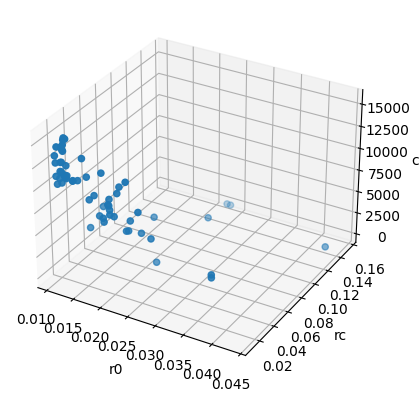

In [9]:
plot.threed_scatter(phi_one_df)

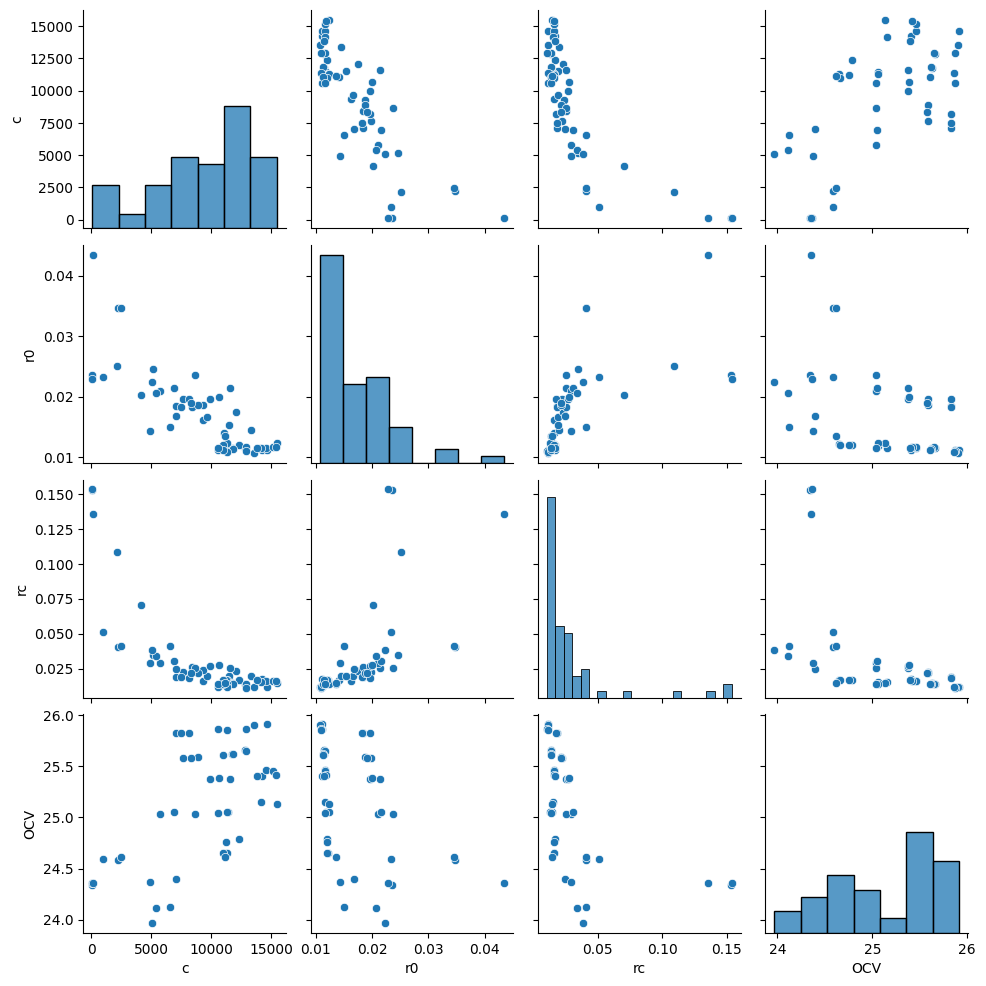

In [10]:
plot.pairwise_scatter(phi_one_df)

Check if the underlinyning distribution is a gaussian, since adaptation routine requires gaussianty

In [11]:
# Shapiro-Wilk test for each variable: Univariate Normality test
for column in phi_one_df.columns:
    stat, p_value = stats.shapiro(phi_one_df[column])
    print(f'{column}: Shapiro-Wilk test stat={stat}, p-value={p_value}')

c: Shapiro-Wilk test stat=0.9358622431755066, p-value=0.003552642185240984
r0: Shapiro-Wilk test stat=0.814231812953949, p-value=3.111978230663226e-07
rc: Shapiro-Wilk test stat=0.5388643145561218, p-value=1.9075199319401603e-12
OCV: Shapiro-Wilk test stat=nan, p-value=1.0


In [12]:
# Mardia's test for multivariate normality
mardia_test = pg.multivariate_normality(phi_one_df, alpha=0.05)
print(mardia_test)

HZResults(hz=2.8467590874785564, pval=4.548522639626467e-22, normal=False)


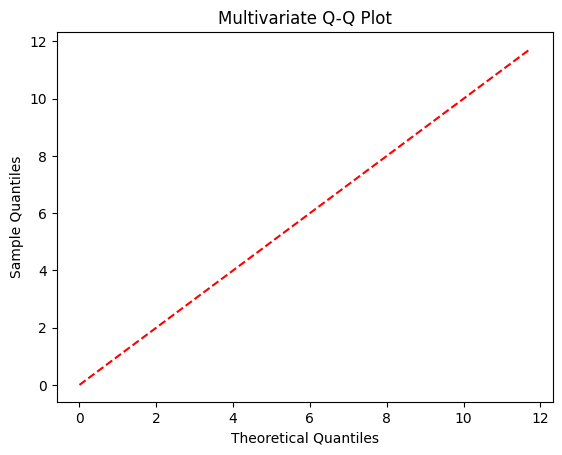

In [13]:
# Calculate the covariance matrix and its inverse
cov_matrix = np.cov(phi_one_df, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mean_values = np.mean(phi_one_df.values, axis=0)

# Calculate Mahalanobis distances for each observation
mahalanobis_distances = []
for i in range(len(phi_one_df)):
    diff = phi_one_df.iloc[i] - mean_values
    md = np.sqrt(diff.T @ inv_cov_matrix @ diff)
    mahalanobis_distances.append(md)

# Sort Mahalanobis distances and theoretical chi-squared quantiles
sorted_md = np.sort(mahalanobis_distances)
chi_squared_values = chi2.ppf((np.arange(1, len(phi_one_df) + 1) - 0.5) / len(phi_one_df), df=3)

# Q-Q plot for Mahalanobis distances
plt.scatter(chi_squared_values, sorted_md)
plt.plot([0, max(chi_squared_values)], [0, max(chi_squared_values)], color='red', linestyle='--')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Multivariate Q-Q Plot')
plt.show()

## Artificial generated Stream of theta: to emulate the ones produced by the optimizer

In [14]:
theta_history_df = load.csv_as_df(theta_history_file_path)

In [15]:
theta_history_df.head()

,r0,rc,c
0,-2.047014,-0.942424,4607.511965
1,0.458922,0.684906,4610.490506
2,2.754147,2.732367,4613.260646
3,0.243590,0.496394,99.122719
4,-0.039785,0.572086,4609.918803


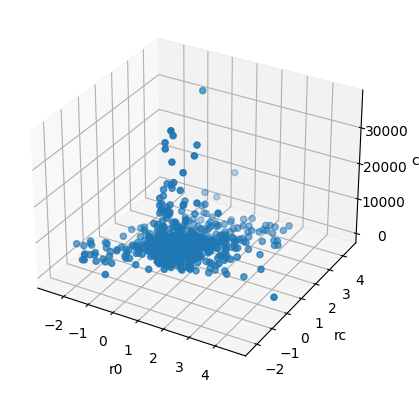

In [16]:
plot.threed_scatter(theta_history_df)

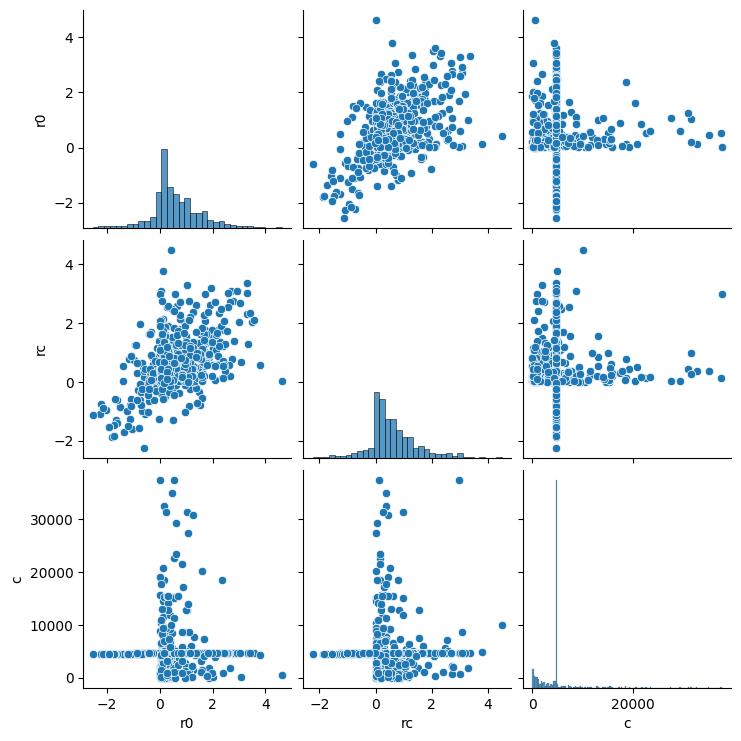

In [17]:
plot.pairwise_scatter(theta_history_df)

build the cluster object

In [18]:
phi_one_df.describe()

,c,r0,rc,OCV
count,60.000000,60.000000,60.000000,48.000000
mean,9338.054441,0.016977,0.029842,25.145042
std,4119.364769,0.006542,0.031361,0.564678
min,103.544660,0.010700,0.011082,23.970000
25%,7019.698113,0.011697,0.014969,24.644250
50%,10630.167240,0.015171,0.019005,25.263000
75%,11866.580522,0.020059,0.028063,25.613250
max,15492.034923,0.043449,0.153520,25.912000


In [19]:
phi_one_df = phi_one_df.dropna
parameters = [row[0:3] for row in phi_one_df.values]
print(parameters[3].shape)
phi_one = Cluster()
phi_one.data_points = parameters
phi_one.compute_centroid()
phi_one.compute_covariance()

AttributeError: 'function' object has no attribute 'values'

In [ ]:
print(phi_one.covariance.shape)

## flow of the adaptation routine

In [ ]:
theta_history_df_cleaned = theta_history_df.dropna
theta_history = theta_history_df_cleaned.values


In [ ]:
np.shape(theta_history)

In [21]:
theta_history = [theta_history[i] for i in range(theta_history.shape[0]) ]

NameError: name 'theta_history' is not defined

In [22]:
outliers = []
for k,theta in enumerate(theta_history):
    if phi_one.contains(theta):
        phi_one.update(theta)
    else:
        outliers.append(theta)
        phi_hat = cluster_estimation(cluster_data_points=phi_one_df.values,
                                                    outliers=np.vstack(outliers))   

NameError: name 'theta_history' is not defined

In [ ]:
plot.samples_and_outliers(samples=phi_one_df.values,
                          outliers=np.vstack(phi_hat.get_parameters()))

In [ ]:
phi_hat_df = pd.DataFrame(np.vstack(phi_hat.get_parameters()), columns= ['r0','rc','c'])

In [ ]:
plot.threed_scatter(phi_hat_df)

In [ ]:
plot.pairwise_scatter(phi_hat_df)

In [ ]:
phi_one_df.describe()

In [ ]:
phi_hat_df.describe()